<a href="https://colab.research.google.com/github/cormac-black/chekhovs-biscuit/blob/main/back_at_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2


what is this? Is this just text?

Image 1



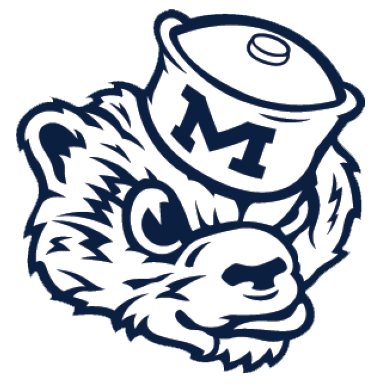

(310, 297, 3)
Image 2



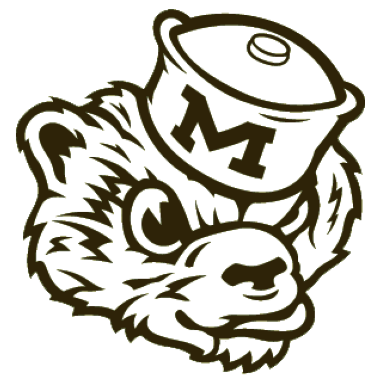

In [ ]:
image = mping.imread('WolverBearR0.png')
plt.imshow(image)
plt.axis('off')
print('Image 1\n')
plt.show()

img_path = 'WolverBearR0.png' # cv2 starts with image path


img_raw = cv2.imread(img_path)
print (img_raw.shape) # Checking (height, width, channels)
img_RGB = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img_RGB_copy = img_RGB.copy()
img_GRAY_copy = cv2.cvtColor(img_RGB_copy, cv2.COLOR_RGB2GRAY)
img_GRAY_blur = cv2.medianBlur(img_GRAY_copy, 11) # Changed ksize from 1 to 3 based on original comment's implied intent

img_filtered = cv2.applyColorMap(img_RGB_copy, cv2.COLORMAP_DEEPGREEN)

edges = cv2.adaptiveThreshold(img_GRAY_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,9,5)
pixel_values = img_RGB_copy.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
k = 8
_, labels, centers = cv2.kmeans(pixel_values, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .2), 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)

quantized_img = centers[labels.flatten()]
quantized_img = quantized_img.reshape(img_filtered.shape)
quantized_img

alpha = 0.7
beta = 0.3
gamma = 0.5

blended_img = cv2.addWeighted(cv2.cvtColor(quantized_img, cv2.COLOR_BGR2RGB), alpha, img_filtered, beta, gamma)

plt.imshow(blended_img)
plt.axis('off')
print('Image 2\n')
plt.show()